In [1]:
import os, time
import matplotlib.pyplot as plt
import numpy as np
import dgl
import dgl.function as fn
import pickle as pkl
import torch
from sklearn.metrics import recall_score, precision_score, roc_auc_score

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import collections

In [3]:
import seaborn
import matplotlib.ticker as ticker

In [4]:
from xgnn_src.node.student import EGNN

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8, 8]

In [6]:
from utils import *
from xgnn_src.node.eval import *

```
python train.py --teacher-name gcn --dataset BAS --n-epochs 500 --n-hidden 32 --n-layers 3 --lr 0.01 --all-layer-dp --skip-norm --add-reverse --gpu 0  --surrogate --student-type egnn --temp 2 --sl-factor 4 --teacher-pretrain ./ckpt/gcn/ba_shape_gcnteacher.pt --load --student-model ./ckpt/gcn/ba_shape_egcnstudent.pt

python train.py --teacher-name gcn --dataset BAC --n-epochs 500 --n-hidden 64 --n-layers 3 --lr 0.01 --all-layer-dp --skip-norm --add-reverse --gpu 0  --surrogate --student-type egnn --temp 2 --sl-factor 4 --teacher-pretrain ./ckpt/gcn/ba_community_gcnteacher.pt --load --student-model ./ckpt/gcn/ba_community_egcnstudent.pt

 python train.py --teacher-name gcn --dataset TRC --n-epochs 500 --n-hidden 64 --n-layers 3 --lr 0.01 --all-layer-dp --skip-norm --add-reverse --gpu 0  --surrogate --student-type egnn --temp 2 --sl-factor 4 --teacher-pretrain ./ckpt/gcn/tree_cycle_gcnteacher.pt --load --student-model ./ckpt/gcn/tree_cycle_egcnstudent.pt

python train.py --teacher-name gcn --dataset TRG --n-epochs 500 --n-hidden 64 --n-layers 3 --lr 0.01 --all-layer-dp --skip-norm --add-reverse --gpu 0  --surrogate --student-type egnn --temp 2 --sl-factor 4 --teacher-pretrain ./ckpt/gcn/tree_grid_gcnteacher.pt --load --student-model ./ckpt/gcn/tree_grid_egcnstudent.pt

```

In [7]:
def load_model_data(dataset, model_name, hidden_size=64, num_classes=2):
    with open('./datasets/%s_bidir.g'%dataset, 'rb') as f:
        g = pkl.load(f)
        g1 = make_slice_l2(g)
    test_labels = g.ndata['label'][g.ndata['test_mask']]
    feats = g.ndata['feat'].size()[1]
    model = EGNN(g, g1, feats, hidden_size, num_classes, 0.5)
    ckpt = torch.load('./ckpt/gcn/%s.pt' % model_name, map_location="cuda:0")
    model.load_state_dict(ckpt)
    return g, g1, model

In [8]:
def predict(model, g):
    model.eval()
    with torch.no_grad():
        preds = model(g.ndata['feat'])
        preds = torch.argmax(preds, 1)
        print((preds[g.ndata['test_mask']] == test_labels).to(torch.float32).mean())

In [9]:
def get_mask(model, g1, g2):
    model.eval()
    with torch.no_grad():
        x1, x2, m1, m2 = model.compute_masks(g1.ndata['feat'])
        g1, g2 = model.g, model.g1
        g1.edata['alpha'] = m1
        g2.edata['alpha'] = m2

In [10]:
def extract_neighbors(g1, g2, idx, top=5):
    l1, _ = g1.in_edges(idx)
    l2, _ = g2.in_edges(idx)

    weights = {}
    def update_weights(g, l, idx, weights):
        for n in l:
            n = n.item()
            w = g.edges[n, idx].data['alpha'].flatten().item()
            if not n in weights:
                weights[n] = w
            else:
                weights[n] += w
    update_weights(g1, l1, idx, weights)
    update_weights(g2, l2, idx, weights)
    indices, values = [], []
    for k, v in weights.items():
        indices.append(k)
        values.append(v)
    if top < len(values):
        top_k = torch.topk(torch.tensor(values), top)
        s_indices = top_k.indices
        selected_indices = [indices[s.item()] for s in s_indices] + [idx]
        values = top_k.values.tolist() + [2.]
        return selected_indices, values
    return indices + [idx], values + [2.]
    

In [11]:
def explain_test(g1, g2, node_id, top=10, ax=None, undir=True, scale=15, plot=True): 
    indices, _ = extract_neighbors(g1, g2, node_id, top)
    ng = dgl.node_subgraph(g1, torch.LongTensor(indices))
    nodes = ng.ndata['_ID']
    labels = {k.item(): v.item() for k, v in zip(ng.nodes(), nodes)}
    edge_probs = [1] * ng.num_edges()
    if plot:
        draw_simple_graph(ng, edge_probs, undir, labels=labels, node_id=node_id, ax=ax) 
    return ng

In [12]:
def evaluate_dataset(g1, g2, selected_node, motifs, s=6, e=14):
    best_options = {}
    reals, preds = [], []
    for i, n in tqdm(enumerate(selected_node)):
        best_idx = -1
        best_rec = 0.
        best_real, best_pred = [], []
        for j in range(s,e):
            ng = explain_test(g1, g2, n, j, plot=False)
            real, pred, tmp_rec = get_preds(motifs[i], ng)
            if best_rec < tmp_rec:
                best_rec = tmp_rec
                best_idx = j
                best_real, best_pred = real, pred
            if best_rec > 0.95:
                break
        best_options[n] = best_idx
        reals.extend(best_real)
        preds.extend(best_pred)
    all_pre = precision_score(reals, preds)
    all_rec = recall_score(reals, preds)
    return all_pre, all_rec, best_options

In [26]:
g, g1, model = load_model_data('ba_shape', 'ba_shape_egcnstudent', 32, 4)
get_mask(model, g, g1)

In [32]:
selected_node = list(range(400, 700, 5))
test_graphs = [extract_true_motif(g, i, 399, 5, True) for i in selected_node]

In [66]:
s = time.time()
pred, rec, best_options = evaluate_dataset(g, g1, selected_node, test_graphs, 5, 15)
print(time.time() - s)

60it [00:02, 25.20it/s]

2.3881313800811768


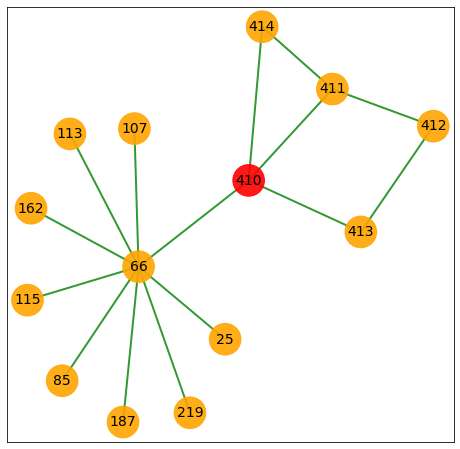

In [69]:
ng = explain_test(g, g1, 410, best_options[410], scale=1)
plt.savefig("./images/egcn_ba_shape_410.pdf", format='pdf', dpi=300)

In [36]:
print("F1 %.4f Precision: %.4f Recall %.4f"  % (pred*rec*2/(pred+rec), pred, rec))

F1 0.7210 Precision: 0.5656 Recall 0.9944


## BA Commnity

In [37]:
cg, cg1, cmodel = load_model_data('ba_community', 'ba_community_egcnstudent', 64, 8)
get_mask(cmodel, cg, cg1)

In [61]:
cg.nodes[66].data['label']

tensor([0])

In [56]:
ctest_graphs = [extract_true_motif(cg, i, 399, 5, True) for i in selected_node]
s = time.time()
pred, rec, cbest_options = evaluate_dataset(cg, cg1, selected_node, ctest_graphs, 5, 20)
print(time.time() - s)
print("F1 %.4f Precision: %.4f Recall %.4f"  % (pred*rec*2/(pred+rec), pred, rec))

60it [00:05, 10.81it/s]

5.559453248977661
F1 0.5873 Precision: 0.4273 Recall 0.9389


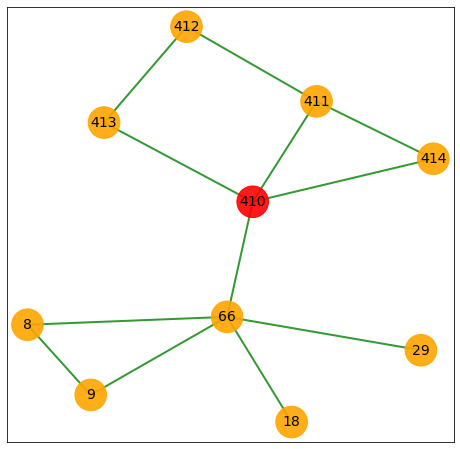

In [70]:
explain_test(cg, cg1, 410, cbest_options[410]+1, scale=1)
plt.savefig("./images/egcn_ba_community_410.pdf", format='pdf', dpi=300)

## Tree Cycle

In [13]:
tg, tg1, tmodel = load_model_data('tree_cycle', 'tree_cycle_egcnstudent', 64, 2)
get_mask(tmodel, tg, tg1)

In [14]:
selected_node = list(range(511,871,6))
test_pentagon = [extract_true_motif(tg, i, 510, 6) for i in selected_node]
s = time.time()
pred, rec, tbest_options = evaluate_dataset(tg, tg1, selected_node, test_pentagon, 5, 30)
print(time.time() - s)
print("F1 %.4f Precision: %.4f Recall %.4f"  % (pred*rec*2/(pred+rec), pred, rec))

60it [00:06,  9.35it/s]

6.422334909439087
F1 0.6210 Precision: 0.5811 Recall 0.6667


Graph(num_nodes=8, num_edges=14,
      ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'alpha': Scheme(shape=(1,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

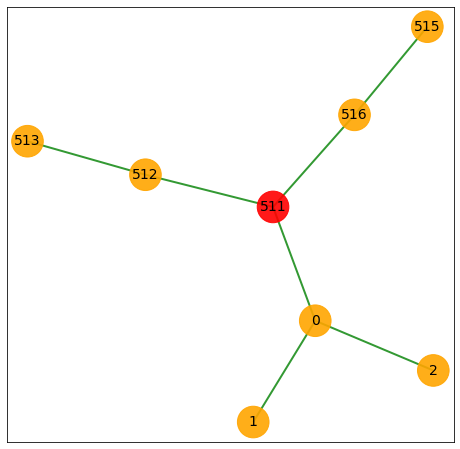

In [21]:
explain_test(tg, tg1, 511, tbest_options[511]+7, scale=10)
# plt.savefig("./images/egcn_tree_cycle_511.pdf", format='pdf', dpi=300)

In [19]:
tgg, tgg1, tgmodel = load_model_data('tree_grid', 'tree_grid_egcnstudent', 64, 2)
get_mask(tgmodel, tgg, tgg1)

In [30]:
selected_node = list(range(511,800,1))
test_ggraphs = [extract_true_motif(tgg, i, 510, 9) for i in selected_node]
s = time.time()
pred, rec, tbest_options = evaluate_dataset(tgg, tgg1, selected_node, test_ggraphs, 10, 20)
print(time.time() - s)
print("F1 %.4f Precision: %.4f Recall %.4f"  % (pred*rec*2/(pred+rec), pred, rec))

289it [00:13, 21.77it/s]

13.31641173362732
F1 0.6966 Precision: 0.7785 Recall 0.6303


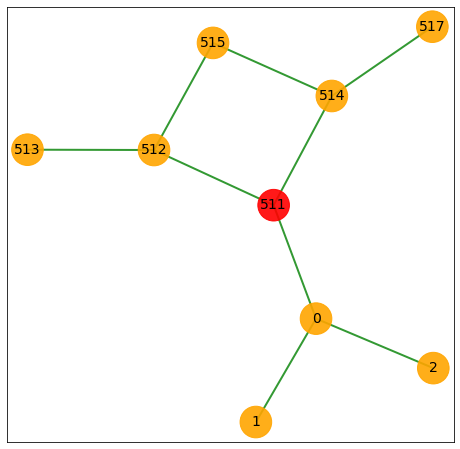

In [26]:
explain_test(tgg, tgg1, 511, tbest_options[511], scale=1)
plt.savefig("./images/egcn_tree_grid_511.pdf", format='pdf', dpi=300)